# Sentiment analysis on stock data

Motivation: Social media, media feeds and news articles produce enormous data quantities relevant to stocks daily, which can be leveraged to predict the general public's feeling towards particular companies and their stock value. This data is in the form of text, which must be converted into numbers to be useful in large scale. To convert the available data, natural language processing (NLP) methods are used. In this notebook, a sentiment analysis ML model will be developed, analyzing tweets and making recommendations about the course of action on specific stocks.

The data is part of [this Udemy course](https://www.udemy.com/course/ml-and-python-in-finance-real-cases-and-practical-solutions)

# Part 0: Import the data

In [354]:
# Start by importing the modules needed in the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import string
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [355]:
# Import the stock news data
stocks_df = pd.read_csv("stock_sentiment.csv")
stocks_df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [356]:
# Show dataframe information
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [357]:
# Check for null values
stocks_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [358]:
# How many unique entries are in the "Sentiment" column?
print("In this setting there are %s possible sentiments." %len(stocks_df['Sentiment'].unique()))

In this setting there are 2 possible sentiments.


# Part 1: Data cleaning

Text data cleaning is a bit more complex than numerical data cleaning. Besides potential null values, for which we already checked, punctuation and "stop words" (e.g. "and", "or", etc) must be removed from the data, since they do not provide useful information and bloat the dataset.

### Part 1a: Removing punctuations

Before cleaning the data, we experiment with the relevant python capabilities.

In [359]:
print('The punctuation characters to be removed are: \n' + string.punctuation)

The punctuation characters to be removed are: 
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [360]:
example = 'This is an, admittedly small, example.'
example_clean = ''.join([c for c in example if c not in string.punctuation])

print('The sentence\n %s \n looks like this after removing punctuation: \n %s ' %(example, example_clean))

The sentence
 This is an, admittedly small, example. 
 looks like this after removing punctuation: 
 This is an admittedly small example 


In [361]:
# Define a punctuation removing function.
# Input: a string
# Output: the string with punctuation characters removed

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])

In [362]:
# Apply the clean function on the stock data

stocks_df['Text w/o punctuation'] = stocks_df['Text'].apply(remove_punctuation)
stocks_df.head()

,Text,Sentiment,Text w/o punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137


## Part 1b: Remove stopwords

To work with text data, the 'string' module is insufficient, therefore the ntlk module is used. In addition to stopwords, all words of one or two letters and the words 'from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year', 'http', 'https' will be removed.

In [363]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print('Some stopwords are: \n'+ ' '.join(stop_words[:10]))

Some stopwords are: 
i me my myself we our ours ourselves you you're


[nltk_data] Downloading package stopwords to /home/anas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [364]:
# Extend the stop_words list
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year', 'http', 'https'])

In [365]:
# Define the stopword removing function
def remove_stopwords(text):
    res = []
    for token in gensim.utils.tokenize(text):
        if len(token)>2 and token not in stop_words:
            res.append(token)
    #Join the individual words back into a single string
    res = ' '.join(res)
    return res

In [366]:
# Clean the text
stocks_df['Text w/o stopwords'] = stocks_df['Text'].apply(remove_stopwords)
stocks_df['Text w/o stopwords and punctuation'] = stocks_df['Text w/o stopwords'].apply(remove_punctuation)
stocks_df.drop(columns=['Sentiment']).head()

,Text,Text w/o punctuation,Text w/o stopwords,Text w/o stopwords and punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ tra...,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ tra...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,user AAP MOVIE 55 return for the FEAGEED indic...,AAP MOVIE return FEA GEED indicator trades AWE...,AAP MOVIE return FEA GEED indicator trades AWE...
2,user I'd be afraid to short AMZN - they are lo...,user Id be afraid to short AMZN they are look...,afraid short AMZN looking like near monopoly e...,afraid short AMZN looking like near monopoly e...
3,MNTA Over 12.00,MNTA Over 1200,MNTA Over,MNTA Over
4,OI Over 21.37,OI Over 2137,Over,Over


# Part 2: Create a wordcloud from the text data

The wordcloud does not offer any significant insights, but it can be used to illustrate the most frequently appearing words.

Wordcloud of the original text data:


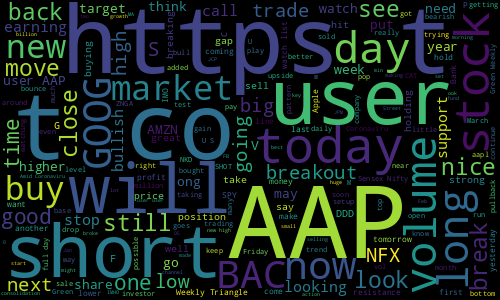

In [367]:
# Visualize all text data
word_cloud = WordCloud(width=500, height=300)
word_cloud = WordCloud.generate(word_cloud, ' '.join(stocks_df['Text'].values))
print('Wordcloud of the original text data:')
word_cloud.to_image()

Wordcloud of the clean text data:


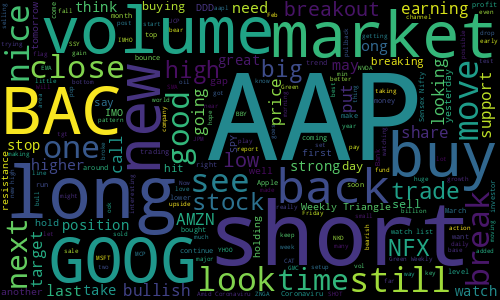

In [368]:
# Visualize the text without punctuation and stopwords
word_cloud = WordCloud(width=500, height=300)
word_cloud = WordCloud.generate(word_cloud, ' '.join(stocks_df['Text w/o stopwords and punctuation'].values))
print('Wordcloud of the clean text data:')
word_cloud.to_image()

Wordcloud of text data with positive sentiment:


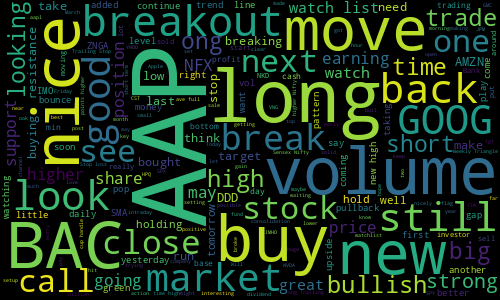

In [369]:
#Visualize the texts with positive sentiment
word_cloud_pos = WordCloud(width=500, height=300)
word_cloud_pos = WordCloud.generate(word_cloud, ' '.join(stocks_df[stocks_df['Sentiment']==1]['Text w/o stopwords and punctuation'].values))
print('Wordcloud of text data with positive sentiment:')
word_cloud_pos.to_image()

Wordcloud of text data with negative sentiment:


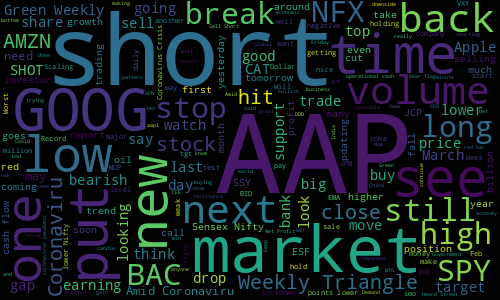

In [370]:
#Visualize the texts with negative sentiments
word_cloud_neg = WordCloud(width=500, height=300)
word_cloud_neg = WordCloud.generate(word_cloud, ' '.join(stocks_df[stocks_df['Sentiment']==0]['Text w/o stopwords and punctuation'].values))
print('Wordcloud of text data with negative sentiment:')
word_cloud_neg.to_image()

Two stock names stand out in both cases: [AAP](https://www.marketwatch.com/investing/stock/aap) (Advance Auto Parts) and [GOOG](https://www.marketwatch.com/investing/stock/goog) (Alphabet, aka Google), whereas [AMZN](https://www.marketwatch.com/investing/stock/goog) only appears in the negative sentiment data.

# Part 3: Visualize the clean texts

The final step of the exploratory data analysis is a statistical analysis of the available data with the corresponding graphs.

In [371]:
# Break up the strings into words using tokenize
nltk.download('punkt')
stocks_df['Text tokenized'] = stocks_df['Text w/o stopwords and punctuation'].apply(word_tokenize)
stocks_df.head()

[nltk_data] Downloading package punkt to /home/anas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Text,Sentiment,Text w/o punctuation,Text w/o stopwords,Text w/o stopwords and punctuation,Text tokenized
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ tra...,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ tra...,"[Kickers, watchlist, XIDE, TIT, SOQ, PNK, CPW,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,AAP MOVIE return FEA GEED indicator trades AWE...,AAP MOVIE return FEA GEED indicator trades AWE...,"[AAP, MOVIE, return, FEA, GEED, indicator, tra..."
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,afraid short AMZN looking like near monopoly e...,afraid short AMZN looking like near monopoly e...,"[afraid, short, AMZN, looking, like, near, mon..."
3,MNTA Over 12.00,1,MNTA Over 1200,MNTA Over,MNTA Over,"[MNTA, Over]"
4,OI Over 21.37,1,OI Over 2137,Over,Over,[Over]


In [372]:
# Examine the length of the tweets
stocks_df['Tweet length'] = stocks_df['Text tokenized'].apply(len)
stocks_df['Tweet length'].describe()

count    5791.000000
mean        8.221205
std         3.897513
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Tweet length, dtype: float64

<AxesSubplot:>

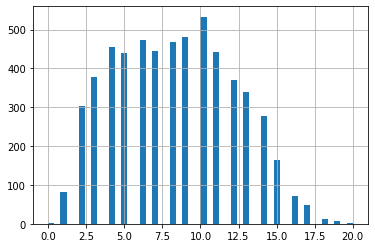

In [373]:
# Plot the tweet length against the absolute frequency
stocks_df['Tweet length'].hist(bins=50)

Postive sentiment tweet length:


<AxesSubplot:>

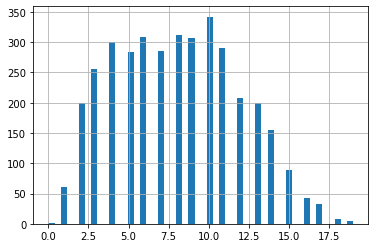

In [374]:
# Plot the positive sentiment tweet length
print('Postive sentiment tweet length:')
stocks_df[stocks_df['Sentiment']==1]['Tweet length'].hist(bins=50)

Negative sentiment tweet length:


<AxesSubplot:>

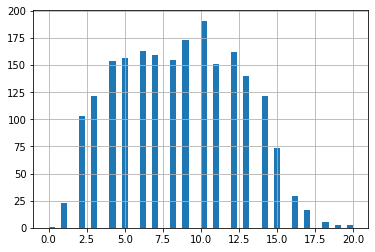

In [375]:
# Plot the negative sentiment tweet length
print('Negative sentiment tweet length:')
stocks_df[stocks_df['Sentiment']==0]['Tweet length'].hist(bins=50)

Observe that some tweets must be removed, since they only contained removed words.

In [376]:
stocks_df = stocks_df[stocks_df['Text tokenized'].apply(len)>1]
stocks_df['Tweet length'].describe()

count    5705.000000
mean        8.330587
std         3.822740
min         2.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Tweet length, dtype: float64

# Part 4: Preprocessing

At this stage the data must be prepared for the machine learning model.
The tweets need to be padded to the same length, and the words must be tokenized.

In [377]:
# Get the total length of the text
total_length = stocks_df['Text tokenized'].apply(len).sum()
print('The cleaned dataset has %s words' %total_length)

The cleaned dataset has 47526 words


In [378]:
# Get the unique words in the dataset
unique_words = stocks_df['Text tokenized'].explode().unique()
print('The dataset has %s unique words' %len(unique_words))

The dataset has 10645 unique words


The dataset isnow split into train and test set. Preprocessing will use only the train set in order to simulate the effects that unknown words will have on the model. In a real world application, there is no guarantee that the train set contains all words that occur in tweets.

In [379]:
# Split into X and y (input and output)
X = stocks_df['Text w/o stopwords and punctuation']
y = stocks_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.head()

885                                      Trade Setup AKAM
1937    AMN Not become penny company continue dilute s...
2305    NIHD Gap likely Also liking action Others Also...
63      Heads Earnings ess Than Week Away Tho The Seas...
3263                                          NSPH peeled
Name: Text w/o stopwords and punctuation, dtype: object

In [380]:
# Create a tokenizer and fit it on the train set
tokenizer = Tokenizer(num_words = total_length)
tokenizer.fit_on_texts(X_train)
# Apply the tokenizer on the train and test tweets
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
# Show the first 5 train sequences
train_sequences[:5]

[[29, 132, 1211],
 [1064, 229, 1813, 1814, 189, 319, 3404, 91, 4, 1479, 339],
 [3405, 46, 211, 178, 1815, 131, 532, 178, 39, 580, 340, 125],
 [1816,
  41,
  1817,
  1065,
  486,
  341,
  820,
  17,
  3406,
  2348,
  2349,
  925,
  3407,
  1480,
  190,
  261],
 [1481, 3408]]

In [381]:
# Pad the sequences to the max length
train_padded = pad_sequences(train_sequences, maxlen=20)
test_padded = pad_sequences(test_sequences, maxlen=20)

At this point the input data is ready. The output needs to be converted to categorical before proceeding.

In [382]:
# Convert the sentiment to categorical data
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Part 5: Build an ML model to determine tweet sentiment
Using TensorFlow a LSTM neural network is built. The network takes a (padded) tweet as input and returns a sentiment. This information can be used to shift through enormous amounts of data and determine how twitter users feel about certain stocks.

In [383]:
# LSTM models are sequential
model = Sequential()

# Add the embedding layer
model.add(Embedding(total_length, output_dim = 512))

# Add the LSTM layer
model.add(LSTM(256))

# Add the dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 512)         24333312  
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 25,153,922
Trainable params: 25,153,922
Non-trainable params: 0
_________________________________________________________________


In [384]:
# train the model
model.fit(train_padded, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2)

Epoch 1/2
115/115 [==============================] - 88s 743ms/step - loss: 0.5674 - acc: 0.6924 - val_loss: 0.5117 - val_acc: 0.7437
Epoch 2/2
115/115 [==============================] - 85s 738ms/step - loss: 0.2706 - acc: 0.8915 - val_loss: 0.5569 - val_acc: 0.7601


# Part 6: Evaluate the model

To evaluate the model, the test tweets are used, and the predictions are compared to the original data. At the end, the confusion matrix is plotted, which demonstrates in detail how the model performed.

In [385]:
# Make a prediction
pred = model.predict(test_padded)
prediction = []
for i in pred:
    prediction.append(np.argmax(i))
    # list containing original values
original = []
for i in y_test_cat:
    original.append(np.argmax(i))# acuracy score on text data

accuracy = accuracy_score(original, prediction)
accuracy

0.7668711656441718

<AxesSubplot:>

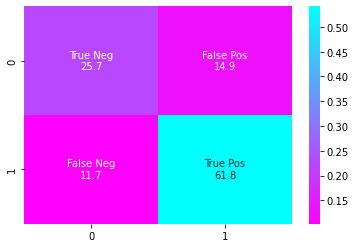

In [408]:
# Plot the confusion matrix
cm = confusion_matrix(original, prediction)/10
labels = ['True Neg\n' + str(cm[0,0]), 'False Pos\n'+ str(cm[0,1]),
          'False Neg\n' + str(cm[1,0]),'True Pos\n' + str(cm[1,1])]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm/np.sum(cm), annot=labels, fmt='', cmap='cool_r')